# Unsupervised Clustering with a Weighted KMeans Autoencoder

In [1]:
# needed modules 
import tensorflow as tf
import keras.backend as K
from keras.layers import Layer, InputSpec, Dense
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.cluster import KMeans 
from preprocessing import *
from autoencoder import *
from sklearn.metrics import *
import matplotlib.pyplot as plt
import sys
import os
import random
import warnings
warnings.filterwarnings("ignore")

1. Preprocess data: 

- set seed universally 
- use 'preprocess.py' to get formatted essays and corresponding labels 
- tokenize essays 
- split essays and labels into training and testing data

In [2]:
# set seed 
set_seed()

# get essays and labels
sentences, labels = preprocess_complete_ver2("../../data/pdf_texts.tsv", "text")
texts = sentences
labels = labels

# tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# text to sequences
sequences = tokenizer.texts_to_sequences(texts)

# pad sequences
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen = max_sequence_length, padding = 'post')

# split train and test data 
total_sentences = len(padded_sequences)
train_ratio = int(total_sentences * 0.8)

train_data = padded_sequences[0:train_ratio]
test_data = padded_sequences[train_ratio:total_sentences]
train_labels = np.array(labels[0:train_ratio])
test_labels = np.array(labels[train_ratio:total_sentences])

Random seed set as 42


2. Run KMeans clustering for a baseline accuracy report 

Produce accuracy metrics and confusion matrix for testing data with regular KMeans clustering. We can use this to see if our autoencoder has improved this clustering algorithm. 

Weighted KMeans clustering accuracy:  0.12195121951219512


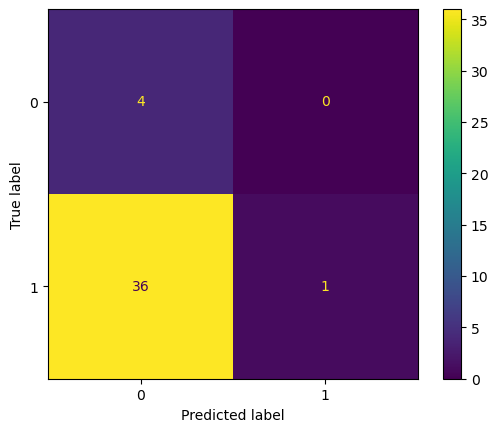

In [3]:
# get labels as weighted lists depending on label frequency
#weight_list_test = get_weights(test_labels)
#weight_list_train = get_weights(train_labels)

# run weighted kmeans clustering
kmeans = KMeans(n_clusters = 2, random_state = 1, init='k-means++', max_iter=100, n_init=1, verbose=0,)
weight_kmeans = kmeans.fit(test_data)
y_pred_kmeans = kmeans.predict(test_data)   

accuracy = accuracy_score(test_labels, y_pred_kmeans)
matrix = get_final_results(test_labels, y_pred_kmeans)

print("Weighted KMeans clustering accuracy: ", accuracy)

# generate confusion matrix 
matrix.plot()

3. Run fully-connected autoencoder to pretrain before clustering

In [3]:
encoder_layer = train_noclustering(train_data, max_sequence_length)

Epoch 1/1500
1/1 [==============================] - 0s 333ms/step - loss: 1090052.3750
Epoch 2/1500
1/1 [==============================] - 0s 14ms/step - loss: 1084184.5000
Epoch 3/1500
1/1 [==============================] - 0s 13ms/step - loss: 1079938.5000
Epoch 4/1500
1/1 [==============================] - 0s 13ms/step - loss: 1076757.1250
Epoch 5/1500
1/1 [==============================] - 0s 13ms/step - loss: 1074244.0000
Epoch 6/1500
1/1 [==============================] - 0s 13ms/step - loss: 1072110.6250
Epoch 7/1500
1/1 [==============================] - 0s 14ms/step - loss: 1070192.2500
Epoch 8/1500
1/1 [==============================] - 0s 13ms/step - loss: 1068347.7500
Epoch 9/1500
1/1 [==============================] - 0s 13ms/step - loss: 1066454.3750
Epoch 10/1500
1/1 [==============================] - 0s 14ms/step - loss: 1064412.0000
Epoch 11/1500
1/1 [==============================] - 0s 13ms/step - loss: 1062121.6250
Epoch 12/1500
1/1 [==============================] 

4. Train clustering autoencoder using the weights from the pretrained model above 

In [4]:
batch_size = 256
n_clusters = 2
clustering_layer = ClusteringLayer(n_clusters)(encoder_layer.output)
clustering_model = Model(inputs = encoder_layer.input, outputs = clustering_layer)
clustering_model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'kld')

# initialize cluster centers 
kmeans = KMeans(n_clusters = n_clusters, n_init = 20)
y_pred = kmeans.fit_predict(encoder_layer.predict(train_data))

y_pred_last = np.copy(y_pred)

clustering_model.get_layer(name = 'clustering_layer').set_weights([kmeans.cluster_centers_])

clustering_model.save_weights('./ae_clustering')

# deep clustering 
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(train_data.shape[0])
tol = -0.0001


## train with clustering 
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = clustering_model.predict(train_data, verbose=0)
        p = target_distn(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if train_labels is not None:
            acc = np.round(accuracy_score(train_labels, y_pred), 5)
            loss = np.round(loss, 5)
        print('Iter %d: acc = %.5f' % (ite, acc), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 1 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, train_data.shape[0])]
    loss = clustering_model.train_on_batch(x = train_data[idx], y = p[idx])
    index = index + 1 if (index + 1) * batch_size <= train_data.shape[0] else 0


6/6 [==============================] - 0s 1ms/step
Iter 0: acc = 0.42857  ; loss= 0
Iter 140: acc = 0.45963  ; loss= 0.0
Iter 280: acc = 0.49068  ; loss= 0.0
Iter 420: acc = 0.50932  ; loss= 0.0
Iter 560: acc = 0.51553  ; loss= 0.0
Iter 700: acc = 0.51553  ; loss= 7e-05
Iter 840: acc = 0.51553  ; loss= 0.00021
Iter 980: acc = 0.52174  ; loss= 0.00016
Iter 1120: acc = 0.52174  ; loss= 0.00011
Iter 1260: acc = 0.52174  ; loss= 0.00018
Iter 1400: acc = 0.52174  ; loss= 5e-05
Iter 1540: acc = 0.52174  ; loss= 4e-05
Iter 1680: acc = 0.52174  ; loss= 2e-05
Iter 1820: acc = 0.52174  ; loss= 2e-05
Iter 1960: acc = 0.52174  ; loss= 1e-05
Iter 2100: acc = 0.52174  ; loss= 1e-05
Iter 2240: acc = 0.52174  ; loss= 0.0
Iter 2380: acc = 0.52174  ; loss= 0.0
Iter 2520: acc = 0.52174  ; loss= 0.0
Iter 2660: acc = 0.52174  ; loss= 0.0
Iter 2800: acc = 0.52174  ; loss= 0.0
Iter 2940: acc = 0.52174  ; loss= 0.0
Iter 3080: acc = 0.52174  ; loss= 0.0
Iter 3220: acc = 0.52174  ; loss= 0.0
Iter 3360: acc = 0.

5. Test clustering autoencoder 

Test accuracy = 0.48780  ; loss =  0.0


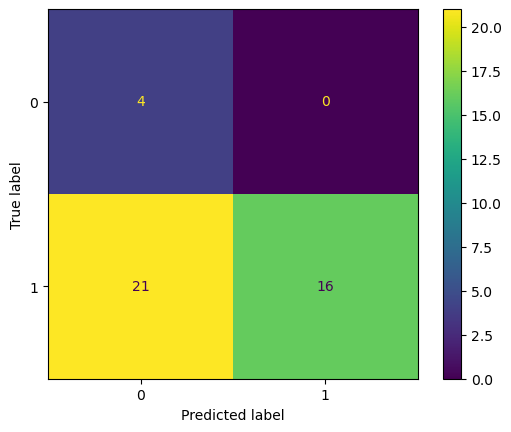

In [6]:
# evaluation testing

clustering_model.load_weights('./ae_clustering')
q = clustering_model.predict(test_data, verbose=0)
p = target_distn(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if test_labels is not None:
    acc = np.round(accuracy_score(test_labels, y_pred), 5)
    loss = np.round(loss, 5)
print('Test accuracy = %.5f' % (acc), ' ; loss = ', loss)

disp = get_final_results(test_labels, y_pred)
disp.plot()